# Análise Bayesiana de amostras da distribuição Normal 

## Referências

[[1]](http://www.stat.columbia.edu/~gelman/book/BDA3.pdf) Andrew Gelman. Bayesian Data Analysis. Parte I, Seção 3.3: essa referência usa a variância ao invés da precisão. 

[[2]](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf) Kevin P. Murphy. Conjugate Bayesian analysis of the Gaussian distribution: Não muito simples, mas possui todas as contas. 

## Precisão da distribuição normal

Definimos $\tau := 1/\sigma^2$ como a precisão da distribuição normal.  

A função da densidade de probabilidade da distribuição normal $f(x|\mu,\tau)$ é, $-\infty < x < \infty$:  

$$
f(x|\mu,\tau) = \left(\frac{\tau}{2\pi}\right)^{1/2}\exp\left[-\frac{1}{2}\tau(x-\mu)^2\right]
$$

### Teorema 

Suponha que $X_1,...,X_n \overset{iid}{\sim}
N_2(\mu, \tau)$, desconhecidos. Suponha que 

$$
\mu|\tau \sim N_2(\mu_0, \lambda_0 \tau)
$$
$$
\tau \sim \text{Gamma}(\alpha_0, \beta_0)
$$

Então a distribuição conjunta de $\mu$ e $\tau$ a posteriori é dada por: 

$$
\mu|\tau, X_1,...,X_n \sim N_2(\mu_1, \lambda_1\tau)
$$
$$
\tau|X_1,...,X_n \sim \text{Gamma}(\alpha_1, \beta_1),
$$

onde 

|Parâmetro|Valor a posteriori do parâmetro|
|----||
|$\mu_1$|$\frac{\lambda_0 \mu_0 + n\bar{x}_n}{\lambda_0 + n}$|
|$\lambda_1$|$\lambda_0 + n$|
|$\alpha_1$|$\alpha_0 + n/2$|
|$\beta_1$|$\beta_0 + s_n^2/2 + \frac{n\lambda_0(\bar{x}_n - \mu_0)^2}{2(\lambda_0 + n)}$|

## Família Normal-Gamma

Sejam $\mu$ e $\tau$ variáveis aleatórias. Suponha que a distribuição condicional de $\mu$ dado $\tau$ é normal com média $\mu_0$ e precisão $\lambda_0 \tau$ e que a distribuição marginal de $\tau$ seja gamma com parâmetros $\alpha_0, \beta_0$. Então, falamos que a distribuição conjunta de $\mu$ e $\tau$ é a distribuição **normal-gamma** com hiperparâmeteros $\mu_0, \lambda_0, \alpha_0$ e $\beta_0$.

## A distribuição marginal da média $\mu$ 

Suponha que a distribuição a priori $\mu$ e $\tau$ seja *normal-gamma* com hiperparâmetros $\mu_0, \lambda_0, \alpha_0$ e $\beta_0$. Então

$$
\left(\frac{\lambda_0\alpha_0}{\beta_0}\right)^{1/2}(\mu - \mu_0)
$$

tem a distribuição $t$ com $2\alpha_0$ graus de liberdade. 

Nesse caso, se $\alpha_0 > 1/2$, $E(\mu) = \mu_0$. Se $\alpha_0 > 1$, $Var(\mu) \frac{\beta_0}{\lambda_0(\alpha_0 - 1)}$

**Obs.:** As condições sobre $\alpha_0$, vem da existência do $k$ momento somente se o grau de liberdade da distribuição $t$ é maior do que $k$, isto é, $2\alpha_0 > k$. 

## Comparação com Intervalos de Confiança

Podemos construir intervalos de confiança para $\mu$ no mundo Bayesiano, pois ela é uma variável aleatória. Nesse caso, podemos fazer da seguinte maneira: 

$$
\begin{split}
&P(-c < \left(\frac{\lambda_0\alpha_0}{\beta_0}\right)^{1/2}(\mu - \mu_0) < c) = \gamma \\
&P(\mu_0 - c\left(\frac{\beta_0}{\lambda_0\alpha_0}\right)^{1/2} < \mu < \mu_0 + c\left(\frac{\beta_0}{\lambda_0\alpha_0}\right)^{1/2}) &= \gamma 
\end{split}
$$

Ou seja, ganhamos um intervalo de confiança de graça!

## Implementação 

Quando temos dados, $X_1, ..., X_n \sim N(\mu, \sigma^2)$, podemos fazer $\hat{\mu} = \bar{X}_n$ que é uma pontual (só para um valor de $\mu$). Mas isso nem sempre é o melhor, e às vezes nem tão prazeroso. Por isso precisamos trazer Bayes para nossa análise. 

In [36]:
import numpy as np 
from scipy.stats import norm, gamma,t
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Nesse exemplos, vamos estudar o exemplo **Casas de Enfermagem em Novo México**, tema estudado por [Howard L. Smith,  Neill F. Piland e Nancy Fisher](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1748-0361.1992.tb00324.x). Nesse trabalho explora os desafios da enfermagem na área rural, para que se mantenha a viabilidade. Vamos utilizar o banco de dados deles, que incluem as seguintes informações: 

1. BED: números de camas na casa. 
2. MCDAYS: dias anuais de internação médica (centenas)
3. TDAYS: total anual de pacientes dias (centenas)
4. PCREV: receita anual total de atendimento ao paciente (centenas)
5. NSAL: salário das enfermeiras anual (centenas)
6. FEXP: despesas anuais com instalações (centenas)
7. RURAL: 1, se rural, 0, se urbano

Os dados se encontram [nesse site](https://math.tntech.edu/ISR/Statistical_Methods_I/Data_and_Story_Library/nursinghome.txt). 

In [2]:
table = []
with open('../data/nursinghome.txt', 'r') as f:
    line = f.readline()
    table.append(line.split())
    line = f.readline()
    while line != '':
        table.append([int(i) for i in line.split()])
        line = f.readline()
nurse_df = pd.DataFrame(data = table[1:], columns = table[0], dtype = np.int)

Vamos considerar nesse exemplo a coluna MCDAYS, restrita às casas urbanas, que denotaremos por $X$. Antes de observarmos os dados, vamos modelar o valor de $X$ para cada casa como uma variável aleatória normal com média $\mu$ e precisão $\tau$. 

In [3]:
urban_nurse_df = nurse_df[nurse_df.RURAL == 0]

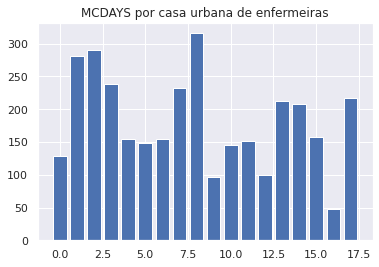

In [37]:
plt.bar(x = range(len(urban_nurse_df)), height = urban_nurse_df.MCDAYS)
plt.title('MCDAYS por casa urbana de enfermeiras')
plt.show()

Para calcular nossa priori, deveríamos conversar com especialistas. Como não é o caso, vamos usar as informações de camas. Temos:

In [10]:
print('Média: {:.1f}, Desvio-Padrão: {:.1f}'. format(np.mean(urban_nurse_df.BED), np.std(urban_nurse_df.BED)))

Média: 111.4, Desvio-Padrão: 42.3


Podemos supor, a priori, que a taxa de ocupação é de 50%. Logo, em um ano, podemos obter que os dias anuais de internação médica são: 

In [11]:
media = 0.5*365*np.mean(urban_nurse_df.BED)/100 # unidade em centenas
std = 0.5*365*np.std(urban_nurse_df.BED)/100

Agora precisamos mapear esses valores para os hiperparâmetros a priori $\alpha_0, \beta_0, \lambda_0, \mu_0$. 

Vamos dibidir a variância obtida acima (usando o número de camas), como incerteza, e dividiremos igualmente essa incerteza sobre a média e a precisão, isto é, 

$$
Var(\mu) = std^2/2
$$

$$
E(\tau) = 1/(std^2/2)
$$

Escolhemos $\alpha_0 = 2$ (arbitrário, mas preferível a ser pequeno, porque esse parâmetro tem a interpretação de ser o conhecimento sobre o valor. 

Logo 
$$
E[\tau] = \alpha_0/\beta_0 \implies \beta_0 = \alpha_0/E[\tau]
$$

$$
E[\mu] = \mu_0
$$

$$
Var(\mu) = \frac{\beta_0}{\lambda_0(\alpha_0 - 1)} \implies \lambda_0 = \frac{\beta_0}{Var(\mu)(\alpha_0 - 1)}
$$

In [83]:
alpha0 = 2
beta0 = alpha*std**2/2
mu0 = media
lambda0 = beta*2/(std**2*(alpha - 1))

Agora conseguimos expressar nosso conhecimento a priori para construir o primeiro intervalo de confiança.  Vamos usar a expressão construída anteriormente. 

Primeiro, vamos ver, numericamente, a distribuição de $\mu$

In [78]:
def draw_samples(alpha0, beta0, lambda0, mu0, seed = 10000):
    
    r = np.random.RandomState(seed)
    tau = r.gamma(shape = alpha0, scale = 1/beta0, size = 100000)
    mu = r.normal(mu0, scale = np.sqrt(1/(lambda0*tau)))
    
    return mu, tau

In [79]:
mu_samples, tau_samples = draw_samples(alpha0, beta0, lambda0, mu0)

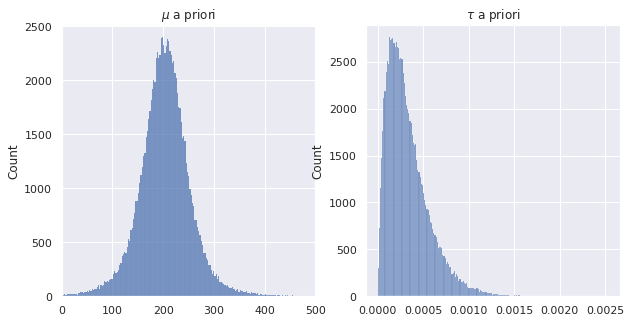

In [80]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.histplot(mu_samples, ax = ax[0])
sns.histplot(tau_samples, ax = ax[1])
ax[0].set_title(r'$\mu$ a priori')
ax[1].set_title(r'$\tau$ a priori')
ax[0].set_xlim((0,500))
plt.show()

In [81]:
ci_mu = (np.quantile(mu_samples, 0.025), np.quantile(mu_samples, 0.975))
print(ci_mu)

(95.85458277508882, 309.0974651995673)


Agora, vamos observar os dados e calcular nossa posteriori! Vamos atualizar como demonstrado no Teorema. 

|Parâmetro|Valor a posteriori do parâmetro|
|----||
|$\mu_1$|$\frac{\lambda_0 \mu_0 + n\bar{x}_n}{\lambda_0 + n}$|
|$\lambda_1$|$\lambda_0 + n$|
|$\alpha_1$|$\alpha_0 + n/2$|
|$\beta_1$|$\beta_0 + s_n^2/2 + \frac{n\lambda_0(\bar{x}_n - \mu_0)^2}{2(\lambda_0 + n)}$|

In [84]:
n = len(urban_nurse_df)
mom1 = np.mean(urban_nurse_df.MCDAYS)
mom2 = np.var(urban_nurse_df.MCDAYS)*n

mu1 = (lambda0*mu0 + n*mom1)/(lambda0 + n)
lambda1 = lambda0 + n
alpha1 = alpha0 + n/2
beta1 = beta0 + mom2/2 + (n*lambda0*(mom1 - mu0)**2)/(2*(lambda0 + n))

In [85]:
mu_samples_post, tau_samples_post = draw_samples(alpha1, beta1, lambda1, mu1)

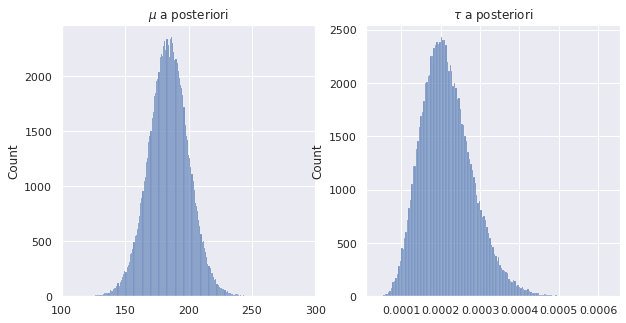

In [90]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.histplot(mu_samples_post, ax = ax[0])
sns.histplot(tau_samples_post, ax = ax[1])
ax[0].set_title(r'$\mu$ a posteriori')
ax[1].set_title(r'$\tau$ a posteriori')
ax[0].set_xlim((100,300))
plt.show()

In [91]:
ci_mu = (np.quantile(mu_samples_post, 0.025), np.quantile(mu_samples_post, 0.975))
print(ci_mu)

(152.61993663355443, 215.58303707725233)


Observe como o intervalo de confiança está bem menor! Ou seja, os dados aumentaram nossa certeza sobre o parâmetro. Vamos comparar os valores. 

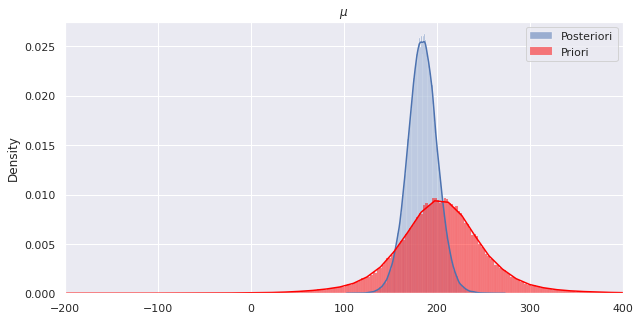

In [100]:
fig, ax = plt.subplots(figsize = (10,5))
sns.histplot(mu_samples_post, ax = ax, kde = True, stat = 'density', label = 'Posteriori')
sns.histplot(mu_samples, ax = ax, kde = True, stat = 'density', label = 'Priori', color = 'red')
ax.set_title(r'$\mu$')
ax.set_xlim((-200,400))
ax.legend()
plt.show()

Por fim, vamos comparar o estimador de Bayes com o de Máxima Verossimilhança: 

In [101]:
mle = mom1 
eb = np.mean(mu_samples_post)
print('MLE: {}'.format(mle))
print('Bayes Estimator: {}'.format(eb))

MLE: 182.16666666666666
Bayes Estimator: 184.21760983937554
